# Enunciado Exercício 6_7 Busca Multimodal por Embedding

Neste exercício, vamos nos utilizar de modelos de processamento de imagem e texto pré-treinados como geradores de embedding. A tarefa é alinhar esses embeddings, de forma que conceitos textuais produzam embeddings similares a imagens correspondentes. Por exemplo, o embedding produzido pela palavra "car" deve ser similar ao embedding de uma imagem de um carro.

A partir deste treinamento, conseguimos implementar uma busca de imagens por query textual!

## Objetivos Específicos
1) Dados: Implemente o DataLoader do dataset fornecido e comente sobre o batch.

2) Arquitetura: Projetar Embeddings de modelos pré-treinados *congelados* para um espaço comum com projeções lineares.

3) Treino: Inicialmente, treinar alinhamento de Embeddings com Mean Square Error (MSE), que alinha somente pares positivos, computando e reportando também o Cosine Similarity.

4) Busca: Implementar query de busca, retornando a imagem correspondente a uma string a partir do Cosine Similarity como medida de similaridade.

5) Melhorar Treinamento: Implementar e treinar com Contrastive Loss, seguindo implementação do paper CLIP leitura dessa semana. A Contrastive Loss deve minimizar a similaridade entre pares de embeddings negativos e maximizar a similaridade entre pares positivos. **Cuidado com composição do batch para Contrastive Loss! Um par de cada classe no máximo**.

6) Busca: Verificar se resultados qualitativos de busca são melhorados com treino com Contrastive Loss.

Dica: guardar os embeddings pré-computados acelera a busca e até o treino.

### Objetivos *Opcionais*
1) (**desafio**) Estratégia de treinamento do SIGLip resolveria o problema de repetições no batch?
2) Modificar busca para retornar resultados rankeados.
3) Usar o CLIP pré-treinado (sem nenhum ajuste) para realizar a busca.


# Exemplo de resultado esperado, com treino com MSE Loss, para query "car"
Similarity: Cosine Similarity entre Embeddings de Imagem projetadas e de Texto



Note que treinando com MSE Loss, embora a resposta esteja correta, a cosine similarity entre pares negativos ainda é alta.

Em teoria, o treino com contrastive loss deve diminuir a similaridade entre pares negativos.

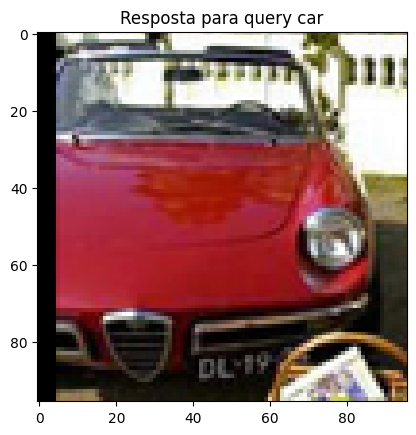

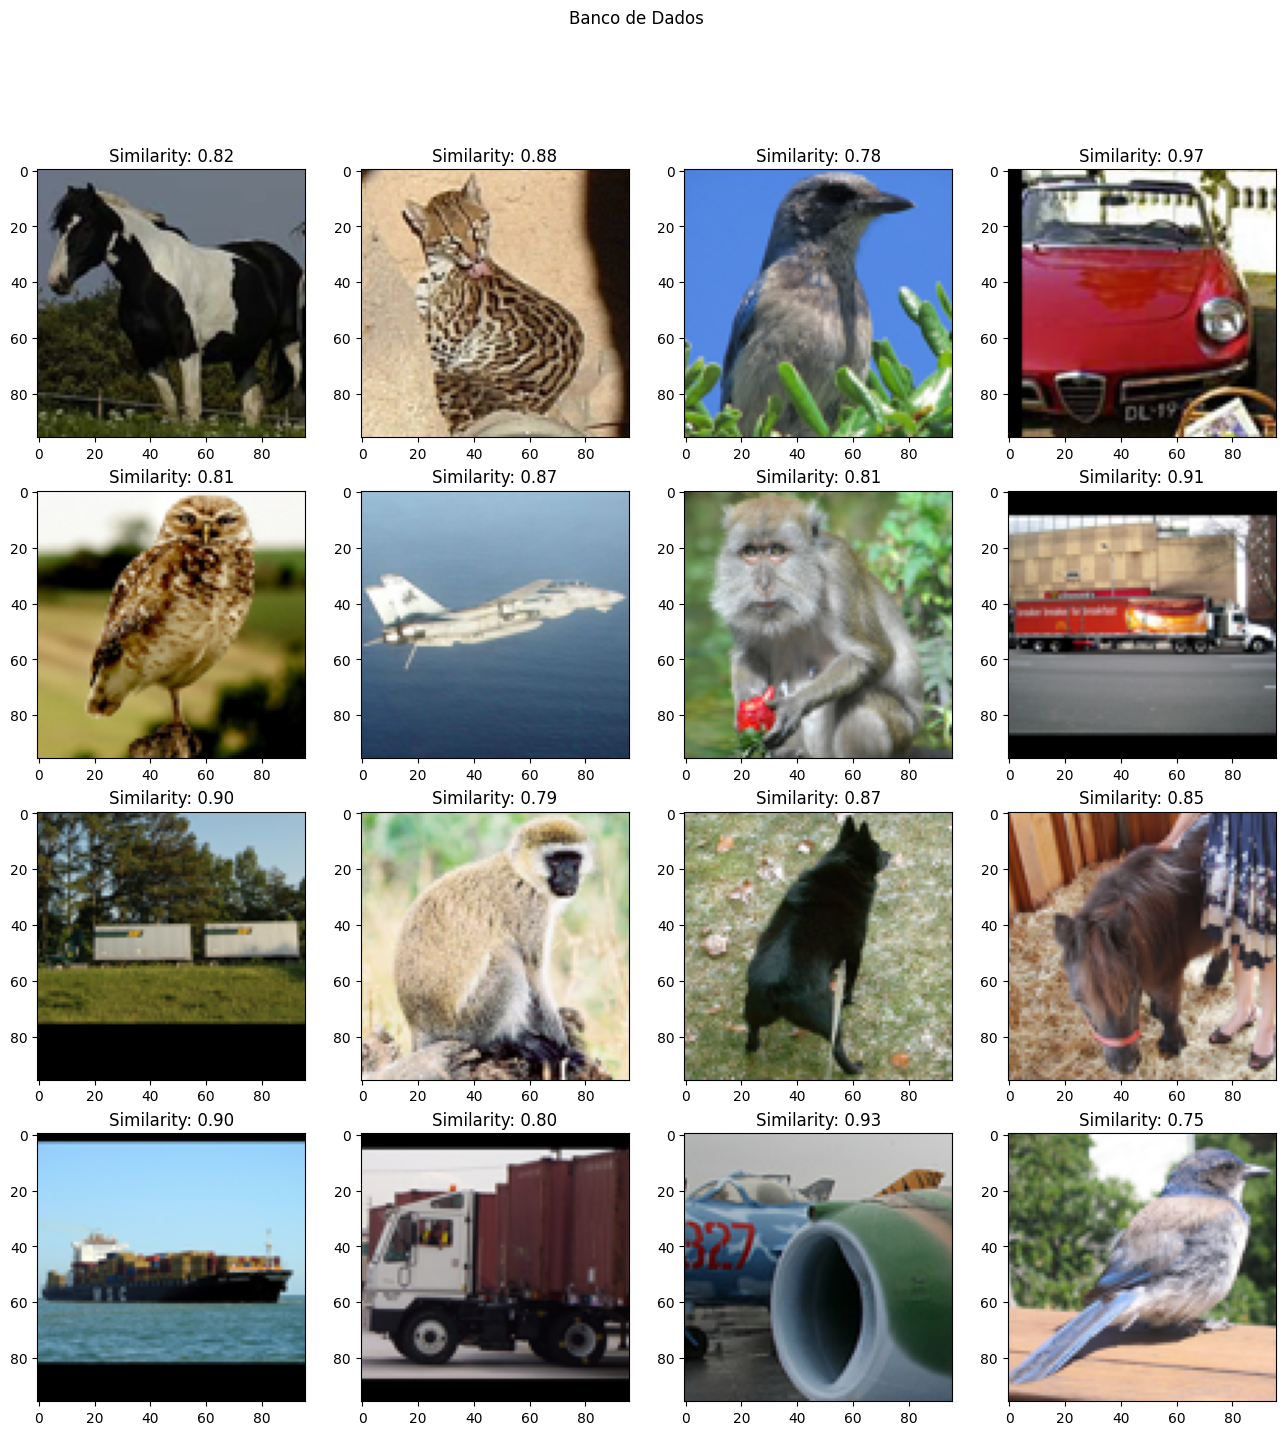

# Imports e bibliotecas

In [ ]:
#!pip install torchinfo efficientnet-pytorch -q

In [ ]:
import os
import math
import pandas as pd
import torch
import random
import logging
import torchinfo
from torch import nn
from pprint import pprint
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10
from transformers import BertModel, BertTokenizer
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [ ]:
print(torch.__version__)

2.8.0


In [ ]:
print(torchvision.__version__)

0.23.0


# Dataset
Implementação do dataset de pares de imagens e textos

In [ ]:
class STLDataset(Dataset):
    '''
    Dataset pronto para treino com MSE Loss

    CUIDADO: Não está correto para contrastive loss!
    '''
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    def __init__(self, mode: str, text_model: str, transform: object):
        # Carrega o dataset
        # STL10 é um dataset de 10 classes, com 5000 imagens de treino e 800 imagens de teste por classe
        self.dataset = STL10(root='./data', split='train' if mode == "train" else "test",  transform=transform, download=True)
        # Carrega o nome das classes
        self.classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

        # Carrega tokenizer: BERT
        self.tokenizer = BertTokenizer.from_pretrained(text_model)
        print(f"Initialized {mode} data.")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        image, label = self.dataset[i] # Le imagem e label do STL10
        text = self.classes[label]     # Le texto correspondente à classe

        text_tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)["input_ids"][0] # Tokeniza o texto

        # retorna imagem, label, texto e texto tokenizado
        return {"image": image,
                "label": label,
                "text": text,
                "text_tokens": text_tokens}

text_model = "bert-base-uncased"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=STLDataset.MEAN, std=STLDataset.STD)])
train_data = STLDataset("train", text_model, transform)
val_data = STLDataset("val", text_model, transform)

Initialized train data.
Initialized val data.


## Debug do Dataset

In [ ]:
train_data[0]

{'image': tensor([[[ 0.3823,  0.3823,  0.3823,  ...,  0.6563,  0.6563,  0.6563],
          [ 0.3823,  0.3823,  0.3823,  ...,  0.6734,  0.6734,  0.6734],
          [ 0.3823,  0.3823,  0.3823,  ...,  0.6906,  0.6906,  0.6906],
          ...,
          [ 0.1083,  0.1426, -0.1143,  ...,  0.2282,  0.4508,  0.2967],
          [ 0.1768,  0.5364, -0.6109,  ...,  0.1939,  0.2111,  0.2282],
          [ 0.1939, -0.4568, -0.1314,  ...,  0.2453,  0.3994,  0.2453]],
 
         [[ 0.4678,  0.4678,  0.4678,  ...,  0.7479,  0.7479,  0.7479],
          [ 0.4678,  0.4678,  0.4678,  ...,  0.7304,  0.7304,  0.7304],
          [ 0.4678,  0.4678,  0.4678,  ...,  0.7304,  0.7304,  0.7304],
          ...,
          [-0.0399,  0.0476, -0.2150,  ...,  0.2752,  0.3803,  0.1001],
          [ 0.0301,  0.4328, -0.7402,  ...,  0.2577,  0.1352,  0.0651],
          [ 0.0476, -0.5826, -0.2150,  ...,  0.1877,  0.3452,  0.2052]],
 
         [[ 0.1128,  0.1128,  0.1128,  ...,  0.3916,  0.3916,  0.3916],
          [ 0.1128,

In [ ]:
# image = tensor da imagem 3 (kernels) x 96 (altura) x 96 (largura)
print(f"Shape image: {train_data[0]['image'].shape} | Type image: {train_data[0]['image'].dtype}")
# label = classe da imagem
print(f"Label: {train_data[0]['label']} | Type label: {type(train_data[0]['label'])}")
# text = texto da classe
print(f"Text: {train_data[0]['text']} | Type text: {type(train_data[0]['text'])}")
# text_tokens = tensor dos tokens do texto
# o texto pode ser uma frase, nao só uma palavra
# cada frase é tokenizada e os tokens sao concatenados em um tensor
print(f"Text tokens: {train_data[0]['text_tokens'].shape} | Type text tokens: {type(train_data[0]['text_tokens'])}")

Shape image: torch.Size([3, 96, 96]) | Type image: torch.float32
Label: 1 | Type label: <class 'int'>
Text: bird | Type text: <class 'str'>
Text tokens: torch.Size([3]) | Type text tokens: <class 'torch.Tensor'>


In [ ]:
# Debug do dataset criado
print(f"Tamanho do dataset de treino: {len(train_data)}")
print(f"Tamanho do dataset de validação: {len(val_data)}")

sample = train_data[0]
print("\nExemplo de item do dataset de treino:")
print(f" - Shape da imagem: {sample['image'].shape} | Tipo: {type(sample['image'])}")
print(f" - Label: {sample['label']} | Tipo: {type(sample['label'])}")
print(f" - Texto: {sample['text']} | Tipo: {type(sample['text'])}")
print(f" - Tokens do texto: {sample['text_tokens']} | Tipo: {type(sample['text_tokens'])}")

Tamanho do dataset de treino: 5000
Tamanho do dataset de validação: 8000

Exemplo de item do dataset de treino:
 - Shape da imagem: torch.Size([3, 96, 96]) | Tipo: <class 'torch.Tensor'>
 - Label: 1 | Tipo: <class 'int'>
 - Texto: bird | Tipo: <class 'str'>
 - Tokens do texto: tensor([ 101, 4743,  102]) | Tipo: <class 'torch.Tensor'>


## DataLoader e Debug do DataLoader


In [ ]:
from torch.utils.data import Sampler

class STLDatasetContrastiva(Sampler):
    '''
    Dataset modificado para Contrastive Loss
    Garante que cada batch tenha no máximo um par de cada classe
    '''
    def __init__(self, dataset, batch_size):
        self.labels = [dataset[i]['label'] for i in range(len(dataset))]
        self.batch_size = batch_size
        self.class_indices = {}
        for idx, label in enumerate(self.labels):
            self.class_indices.setdefault(label, []).append(idx)
        self.classes = list(self.class_indices.keys())
        self.num_batches = len(self.labels) // batch_size

    def __iter__(self):
        for _ in range(self.num_batches):
            chosen_classes = random.sample(self.classes, self.batch_size)
            batch = [random.choice(self.class_indices[c]) for c in chosen_classes]
            yield batch

    def __len__(self):
        return self.num_batches

In [ ]:
def collate_fn(batch):
    # Junta os itens do batch em tensores
    images = torch.stack([item['image'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    texts = [item['text'] for item in batch]
    text_tokens = torch.nn.utils.rnn.pad_sequence(
        [item['text_tokens'] for item in batch], batch_first=True, padding_value=0
    )
    return {
        'image': images,
        'label': labels,
        'text': texts,
        'text_tokens': text_tokens
    }


In [ ]:
# Exemplo de uso:
BATCH_SIZE = 10  # igual ao número de classes do STL10
train_sampler = STLDatasetContrastiva(train_data, BATCH_SIZE)
train_loader = DataLoader(train_data, batch_sampler=train_sampler, collate_fn=collate_fn)

val_sampler = STLDatasetContrastiva(val_data, BATCH_SIZE)
val_loader = DataLoader(val_data, batch_sampler=val_sampler, collate_fn=collate_fn)

In [ ]:
# Pegando um batch do train_loader
batch = next(iter(train_loader))

# Visualizando as chaves e shapes dos itens do batch
print("Chaves do batch:", batch.keys())
print("Shape das imagens:", batch['image'][:5])                # Esperado: (batch_size, 3, 96, 96)
print("Shape dos labels:", batch['label'].shape)                 # Esperado: (batch_size,)
print("Shape dos textos:", len(batch['text']), batch['text'])    # Esperado: batch_size (lista de strings)
print("Shape dos tokens de texto:", batch['text_tokens'].shape)  # Esperado: (batch_size, seq_len)

# Conferindo alguns exemplos do batch
print("\nExemplo de texto e label do batch:")
for i in range(3):
    print(f"  Texto: {batch['text'][i]} | Label: {batch['label'][i]} | Tokens: {batch['text_tokens'][i]}")

Chaves do batch: dict_keys(['image', 'label', 'text', 'text_tokens'])
Shape das imagens: tensor([[[[-0.3198, -0.3198, -0.2513,  ..., -0.1828, -0.2342, -0.2171],
          [-0.3027, -0.2856, -0.2684,  ..., -0.1657, -0.2171, -0.2171],
          [-0.2856, -0.2856, -0.2856,  ..., -0.1999, -0.2171, -0.2171],
          ...,
          [-0.0287, -0.0629, -0.0972,  ..., -0.0801, -0.0629, -0.0458],
          [-0.0458, -0.0801, -0.0629,  ..., -0.0629, -0.0801, -0.0629],
          [ 0.0056,  0.0056, -0.0458,  ..., -0.0458, -0.0458, -0.0458]],

         [[ 0.5728,  0.5728,  0.6254,  ...,  0.6429,  0.6604,  0.6779],
          [ 0.5903,  0.6078,  0.6254,  ...,  0.6604,  0.6779,  0.6779],
          [ 0.6078,  0.6078,  0.6078,  ...,  0.6429,  0.6429,  0.6429],
          ...,
          [ 0.8179,  0.7829,  0.7479,  ...,  0.8004,  0.8004,  0.8354],
          [ 0.8354,  0.8004,  0.8004,  ...,  0.8179,  0.8004,  0.8179],
          [ 0.8704,  0.8704,  0.8179,  ...,  0.8354,  0.8004,  0.8004]],

         [[ 1

# Arquitetura

Utilizamos modelos pré-treinados congelados e treinamos uma camada de projeção de um Embedding para o espaço do outro.

O design aqui é livre e você pode experimentar com modelos pré-treinados diferentes, mais de uma projeção linear, não congelar um dos modelos grandes (pesado), etc.

In [ ]:
print(f'Verificando saídas do EfficientNet:')

model = EfficientNet.from_pretrained(model_name="efficientnet-b0")

inputs = train_data[0]['image'].unsqueeze(0)
outputs = model(inputs)

print(outputs.shape)
# torch.Size([1 = batch_size, 1000 = num_classes])

Verificando saídas do EfficientNet:
Loaded pretrained weights for efficientnet-b0
torch.Size([1, 1000])


In [ ]:
class ImageModel(nn.Module):
    """"
    Modelo de imagem
    Entrada: imagem 3 (kernels) x 96 (altura) x 96 (largura)
    Saída: embedding de imagem
    """
    def __init__(
            self,
            image_model: str = "efficientnet-b0",
            freeze: bool = True,
            emb_size: int = 768
        ):
        super().__init__()

        # Gerador de Embeddings a partir de imagens
        self.image_model = EfficientNet.from_pretrained(image_model)

        # Congelamento do modelo pre-treinado
        if freeze:
            for param in self.image_model.parameters():
                param.requires_grad = False

        # Pesos de projeção dos embeddings não são congelados!
        # Dica: uma boa representação linear da imagem é a entrada da camada Fully Connected da EfficientNet que classifica imagens.
        # Neste exemplo, substituimos ela por nossa projeção para o tamanho de embedding do BERT (emb_size)
        self.image_model._fc = nn.Linear(self.image_model._fc.in_features, emb_size)

        # Se congelou o modelo, precisamos garantir que a nova camada _fc NÃO está congelada:
        #if freeze:
        #    for param in self.image_model._fc.parameters():
        #        param.requires_grad = True

        self.output_dim = emb_size

    def forward(self, x):
        return self.image_model(x)

In [ ]:
print(f'Verificando saídas do BERT:')

model = BertModel.from_pretrained(text_model, output_hidden_states=True)
tokenizer_teste = BertTokenizer.from_pretrained(text_model)

inputs = tokenizer_teste("Exemplo de frase", return_tensors="pt")
outputs = model(**inputs)

print(outputs.keys())
# dict_keys(['last_hidden_state', 'pooler_output'])

print('\n- Dimensões do last_hidden_state:', outputs.last_hidden_state.shape)
# torch.Size([1, sequence_length, hidden_size])

print('- Dimensões do pooler_output:', outputs.pooler_output.shape)
# torch.Size([1, hidden_size])

print('- Dimensões do último hidden state:', outputs.hidden_states[-1].shape)

print('- Tamanho do vocabulário:', len(train_data.tokenizer.vocab))

Verificando saídas do BERT:
odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

- Dimensões do last_hidden_state: torch.Size([1, 9, 768])
- Dimensões do pooler_output: torch.Size([1, 768])
- Dimensões do último hidden state: torch.Size([1, 9, 768])
- Tamanho do vocabulário: 30522


In [ ]:
class TextModel(nn.Module):
    """
    Modelo de texto
    Entrada: texto (tokenizado)
    Saída: embedding de texto
    """
    def __init__(
            self,
            text_model: str = text_model, # bert-base-uncased definido anteriormente,
            freeze: bool = True
        ):
        super().__init__()

        # Importando BERT pre-treinado
        self.bert = BertModel.from_pretrained(text_model)

        # Congelando pesos do modelo pre-treinado
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.output_dim = self.bert.config.hidden_size # 768

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Implementando o forward no BERT, retornando os Embeddings
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # Retorna os embeddings da [CLS] token (pode ser outputs.last_hidden_state também)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size=768]
        return cls_embedding

## Implementação da arquitetura multimodal
Vamos unir instâncias das classes de interpretação de imagem e texto acima para retornar os dois embeddings pareados para treino.

In [ ]:
import torch.nn.functional as F

In [ ]:
class Multimodal(nn.Module):
    def __init__(self, image_model_args={}, text_model_args={}, embed_dim=768):
        super().__init__()
        # Inicializar o ImageModel, TextModel, ajuste parâmetros para sua preferência
        self.image_model = ImageModel(**image_model_args)
        self.text_model = TextModel(**text_model_args)

        # Projeções para garantir que ambos os embeddings tenham a mesma dimensão
        # se mudar o embed_dim padrao, podemos usar outro tamanho de embedding diferente do BERT
        self.image_proj = nn.Linear(self.image_model.output_dim, embed_dim)
        self.text_proj = nn.Linear(self.text_model.output_dim, embed_dim)


    def forward(self, image, text, attention_mask=None):
        # Extrai imagens e textos do batch
        #images = batch['image'].float()
        #texts = batch['text']

        # Obtém os embeddings
        image_emb = self.image_model(image)  # (batch_size, image_emb_dim)

        attention_mask = (text != 0).long()
        text_emb = self.text_model(text, attention_mask=attention_mask)     # (batch_size, text_emb_dim)

        # Projeta ambos para a mesma dimensão
        image_emb = self.image_proj(image_emb)  # (batch_size, embed_dim)
        text_emb = self.text_proj(text_emb)     # (batch_size, embed_dim)

        # Normaliza os embeddings
        image_emb = F.normalize(image_emb, p=2, dim=1)
        text_emb = F.normalize(text_emb, p=2, dim=1)

        # Assert para garantir que as dimensões batem
        assert image_emb.shape == text_emb.shape, \
            f"Dimensões diferentes: {image_emb.shape} vs {text_emb.shape}"

        # Retorna os embeddings pareados
        return image_emb, text_emb

## Visualização dos parâmetros
Visualize a arquitetura para checar se está correta

In [ ]:
torchinfo.summary(Multimodal(embed_dim=256), depth=3)

Loaded pretrained weights for efficientnet-b0


Layer (type:depth-idx)                                            Param #
Multimodal                                                        --
├─ImageModel: 1-1                                                 --
│    └─EfficientNet: 2-1                                          --
│    │    └─Conv2dStaticSamePadding: 3-1                          (864)
│    │    └─BatchNorm2d: 3-2                                      (64)
│    │    └─ModuleList: 3-3                                       (3,594,460)
│    │    └─Conv2dStaticSamePadding: 3-4                          (409,600)
│    │    └─BatchNorm2d: 3-5                                      (2,560)
│    │    └─AdaptiveAvgPool2d: 3-6                                --
│    │    └─Dropout: 3-7                                          --
│    │    └─Linear: 3-8                                           983,808
│    │    └─MemoryEfficientSwish: 3-9                             --
├─TextModel: 1-2                                                  -

# Treinamento com MSELoss
Implemente o treinamento, primeiro utilizando MSELoss

In [ ]:
from torch.nn import MSELoss
mse_loss = MSELoss()

In [ ]:
# define finçao de treinamento e validação
def train_batch(model, batch, optimizer, device, criterion=nn.MSELoss()):
    model.train()

    # X, Y = data
    image, text = batch['image'], batch['text_tokens']
    image, text = image.to(device), text.to(device)


    # forward pass
    image_emb, text_emb = model(image,text) # [B, embed_dim]

    # backward pass
    optimizer.zero_grad()
    loss = criterion(image_emb, text_emb)
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def validate_batch(model, batch, device, criterion=nn.MSELoss()):
    model.eval()

    image, text = batch['image'], batch['text_tokens']
    image, text = image.to(device), text.to(device)

    image_emb, text_emb = model(image, text)
    loss = criterion(image_emb, text_emb)
    return loss.item()

In [ ]:
import time

In [ ]:
# define função de treinamento do modelo
def train_model(model, train_loader, val_loader, optimizer, device, criterion, epochs, patience=3):

    # treinamento
    model.to(device)

    losses_train = []  # losses for plotting
    losses_val = []  # losses for plotting

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        N = len(train_loader)  # number of batches
        train_loss = 0.0
        val_loss = 0.0
        start_time = time.time()

        model.train()
        for batch in train_loader:
            batch_loss = train_batch(model, batch, optimizer, device, criterion)
            train_loss += batch_loss

        epoch_loss = train_loss / N  # average loss for the epoch
        losses_train.append(epoch_loss)

        epoch_duration = time.time() - start_time

        N = len(val_loader)  # number of batches
        model.eval()
        for batch in val_loader:
            batch_loss = validate_batch(model, batch, device, criterion)
            val_loss += batch_loss

        epoch_loss_val = val_loss / N  # average loss for the epoch
        losses_val.append(epoch_loss_val)

        print(f'Epoch [{epoch+1}/{epochs}] | ',
              f'Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_loss_val:.4f} | ',
              f'Time: {epoch_duration:.2f}s')

        # Early stopping
        if epoch_loss_val < best_val_loss:
            best_val_loss = epoch_loss_val
            patience_counter = 0
            # Se quiser salvar o melhor modelo:
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(
                    f"Early stopping em {epoch+1} épocas! Melhor val_loss: {best_val_loss:.4f}")
                break

    return losses_train, losses_val, model

In [ ]:
epochs = 10
lr = 0.001
criterion = nn.MSELoss()

model = Multimodal(embed_dim=256)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

Loaded pretrained weights for efficientnet-b0


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [ ]:
losses_train, losses_val, model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    patience=2
)

Epoch [1/10] |  Train Loss: 0.0002 | Val Loss: 0.0010 |  Time: 13.24s
Epoch [2/10] |  Train Loss: 0.0001 | Val Loss: 0.0007 |  Time: 14.05s
Epoch [3/10] |  Train Loss: 0.0001 | Val Loss: 0.0007 |  Time: 13.36s
Epoch [4/10] |  Train Loss: 0.0000 | Val Loss: 0.0006 |  Time: 14.90s
Epoch [5/10] |  Train Loss: 0.0000 | Val Loss: 0.0007 |  Time: 13.49s
Epoch [6/10] |  Train Loss: 0.0000 | Val Loss: 0.0006 |  Time: 13.33s
Epoch [7/10] |  Train Loss: 0.0000 | Val Loss: 0.0006 |  Time: 14.64s
Epoch [8/10] |  Train Loss: 0.0001 | Val Loss: 0.0005 |  Time: 13.03s
Epoch [9/10] |  Train Loss: 0.0000 | Val Loss: 0.0005 |  Time: 13.21s
Epoch [10/10] |  Train Loss: 0.0000 | Val Loss: 0.0006 |  Time: 13.58s


In [ ]:
def plot_losses_(losses_train, losses_val):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.plot(losses_train, label='Train Loss')
    ax.plot(losses_val, label='Val Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Train and Val Loss')
    ax.legend()
    ax.grid()

    plt.tight_layout()
    plt.show()

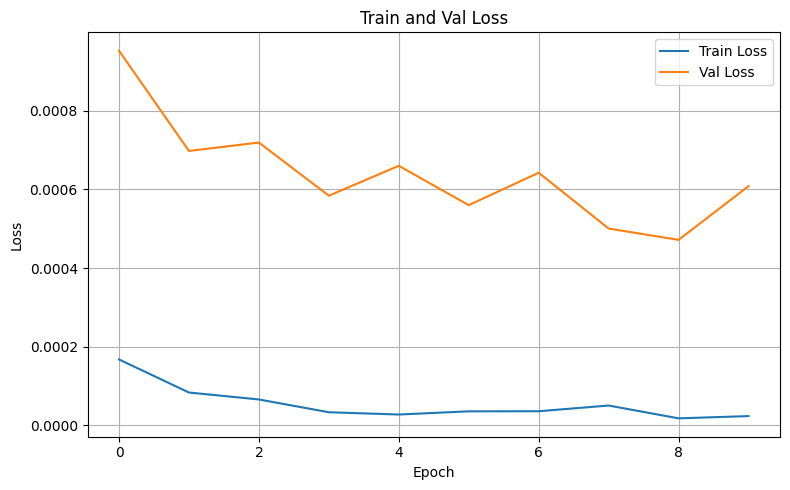

In [ ]:
plot_losses_(losses_train, losses_val)  # plot losses

# Query
Com um batch de imagens e uma string única de query, retorne qual a imagem correspondente usando Cosine Similarity (exemplo de saída esperada no início do notebook)

Faça debugs e confirme que está funcionando corretamente..

In [ ]:
def query(multimodal_model: Multimodal,
          query: str,
          images,
          plot_image: bool = True,
          plot_top_images: int = 6
          ):
    """
    Dado um batch de imagens (tensor [B, 3, 96, 96]) e uma string de query,
    retorna o índice da imagem mais similar à query textual usando Cosine Similarity.
    """
    multimodal_model.eval()
    images = images.to(device)

    # Tokeniza a query usando o tokenizer do dataset
    tokenizer = train_data.tokenizer
    tokens = tokenizer(query, return_tensors="pt", padding=True, truncation=True)
    input_ids = tokens["input_ids"].to(device)
    #attention_mask = (input_ids != 0).long()  # Ignora padding

    # Extrai embeddings das imagens
    with torch.no_grad():
        image_embeds = multimodal_model.image_model(images)
        image_embeds = multimodal_model.image_proj(image_embeds)
        image_embeds = F.normalize(image_embeds, dim=-1)

        # Extrai embedding do texto
        text_embeds = multimodal_model.text_model(input_ids)
        text_embeds = multimodal_model.text_proj(text_embeds)
        text_embeds = F.normalize(text_embeds, dim=-1)

        # Calcula similaridade de cosseno
        similarities = F.cosine_similarity(image_embeds, text_embeds, dim=1)  # shape: [batch]
        best_idx = similarities.argmax().item()

    images_cpu = images.cpu()
    similarities_cpu = similarities.cpu()

    # Plotar imagem mais similar
    # Plotting code remains the same but uses CPU tensors
    if plot_image:
        plt.imshow(images_cpu[best_idx].permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title(f'Query: {query} | Similarity: {similarities_cpu[best_idx]:.2f}')
        plt.show()

    if plot_top_images > 1:
        top_similarities, top_indices = similarities_cpu.topk(plot_top_images)
        top_images = images_cpu[top_indices]

        fig, axes = plt.subplots(1, plot_top_images, figsize=(16, 4))
        for i, ax in enumerate(axes):
            img = top_images[i].permute(1, 2, 0)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = torch.clamp(img, 0, 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Similarity: {top_similarities[i]:.2f}')

        plt.suptitle(f'Query: {query} | Top {plot_top_images} similarities')
        plt.show()

        # Bottom similarities
        bottom_similarities, bottom_indices = similarities_cpu.topk(plot_top_images, largest=False)
        bottom_images = images_cpu[bottom_indices]

        fig, axes = plt.subplots(1, plot_top_images, figsize=(16, 4))
        for i, ax in enumerate(axes):
            img = bottom_images[i].permute(1, 2, 0)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = torch.clamp(img, 0, 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Similarity: {bottom_similarities[i]:.2f}')

        plt.suptitle(f'Query: {query} | Top {plot_top_images} least similarities')
        plt.show()

    return best_idx  # ou images[best_idx] para retornar a imagem

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # ignora warnings para melhorar a visualização

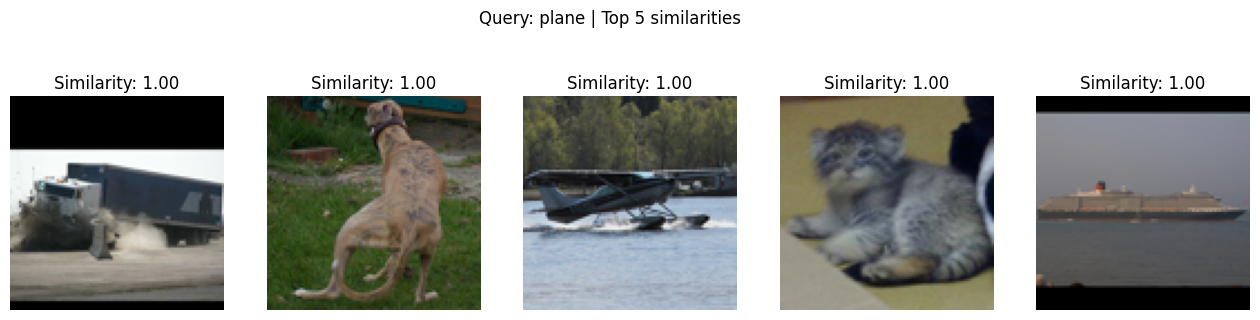

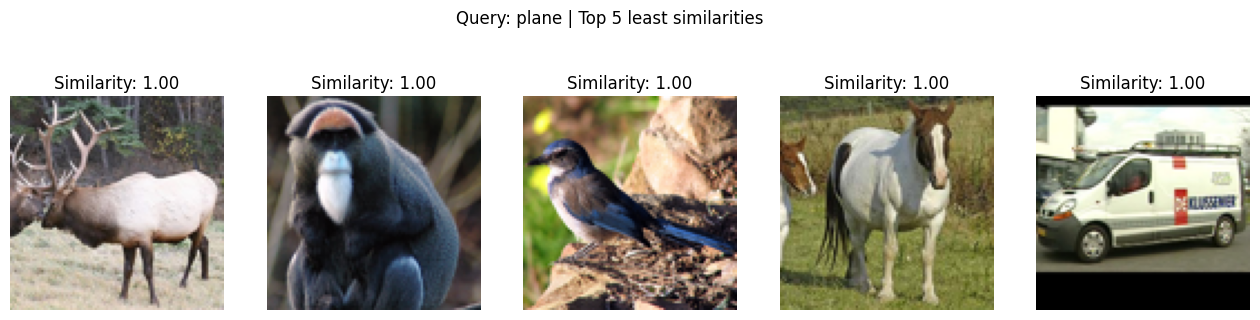

1

In [ ]:
# definindo exemplo de batch de imagens
batch = next(iter(val_loader))
query(model, "plane", batch['image'], plot_image=False, plot_top_images=5)  # retorna o índice da imagem

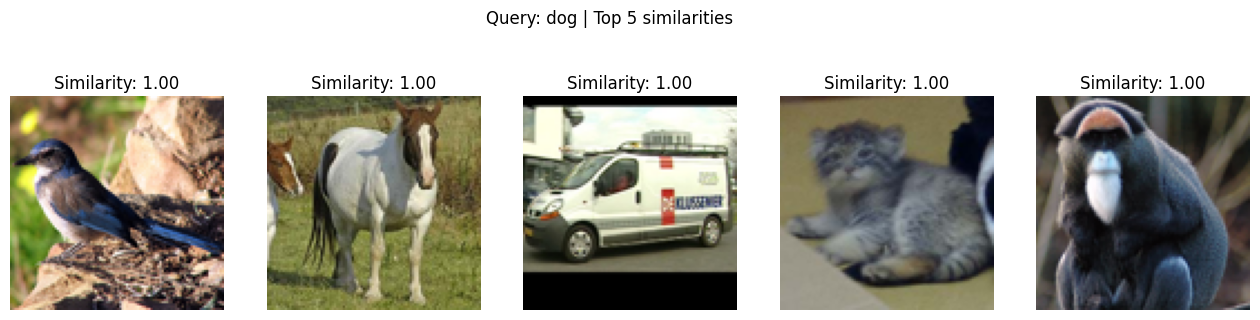

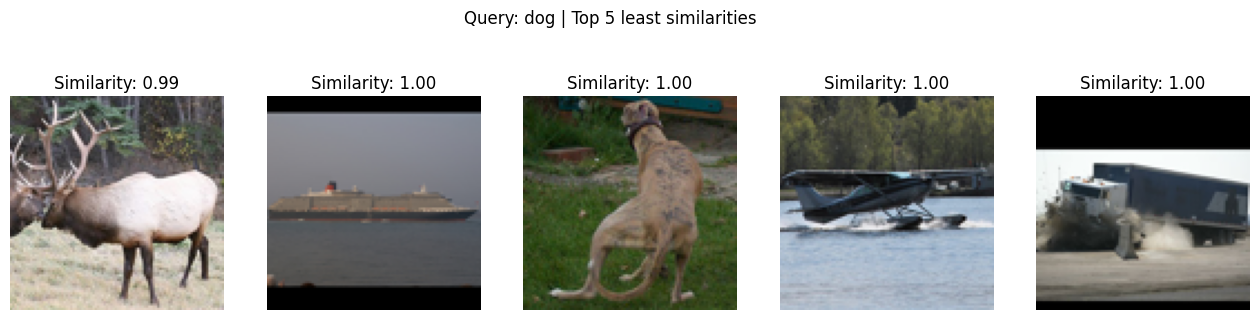

3

In [ ]:
query(model, "dog", batch['image'], plot_image=False, plot_top_images=5)  # retorna o índice da imagem

# Treinamento com  Contrastive Loss
Implemente contrastive loss inspirada pelo CLIP e treine novamente

## Função de perda

In [ ]:
def contrastive_loss(x, y):
    """"
    Função de loss contrastiva
    x: image embeddings
    y: text embeddings
    """
    batch_size = x.shape[0]

    # Calcula similaridade
    logits = torch.matmul(x, y.T)  # shape: [batch, batch]

    # Label binária: 1 se é o mesmo par, 0 se é diferente
    # diagonal é o mesmo par, fora da diagonal é diferente
    labels = torch.arange(batch_size).to(logits.device)

    # Loss simétrica do CLIP
    loss_i_t = F.cross_entropy(logits, labels)    # loss de image para text
    loss_t_i = F.cross_entropy(logits.T, labels)  # loss de text para image

    # Calcula a perda contrastiva
    loss = (loss_i_t + loss_t_i) / 2

    return loss

## Modificando batch

In [ ]:
from torch.utils.data import Sampler

class STLDatasetContrastiva(Sampler):
    '''
    Dataset modificado para Contrastive Loss
    Garante que cada batch tenha no máximo um par de cada classe
    '''
    def __init__(self, dataset, batch_size):
        self.labels = [dataset[i]['label'] for i in range(len(dataset))]
        self.batch_size = batch_size
        self.class_indices = {}
        for idx, label in enumerate(self.labels):
            self.class_indices.setdefault(label, []).append(idx)
        self.classes = list(self.class_indices.keys())
        self.num_batches = len(self.labels) // batch_size

    def __iter__(self):
        for _ in range(self.num_batches):
            chosen_classes = random.sample(self.classes, self.batch_size)
            batch = [random.choice(self.class_indices[c]) for c in chosen_classes]
            yield batch

    def __len__(self):
        return self.num_batches

In [ ]:
def collate_fn(batch):
    # Junta os itens do batch em tensores
    images = torch.stack([item['image'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    texts = [item['text'] for item in batch]
    text_tokens = torch.nn.utils.rnn.pad_sequence(
        [item['text_tokens'] for item in batch], batch_first=True, padding_value=0
    )
    return {
        'image': images,
        'label': labels,
        'text': texts,
        'text_tokens': text_tokens
    }


In [ ]:
BATCH_SIZE = 10  # igual ao número de classes do STL10
train_sampler = STLDatasetContrastiva(train_data, BATCH_SIZE)
train_loader = DataLoader(train_data, batch_sampler=train_sampler, collate_fn=collate_fn)

val_sampler = STLDatasetContrastiva(val_data, BATCH_SIZE)
val_loader = DataLoader(val_data, batch_sampler=val_sampler, collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print("Imagens shape:", batch['image'].shape)
print("Labels:", batch['label'])
print("Textos:", batch['text'])
print("Text tokens shape:", batch['text_tokens'].shape)

Batch keys: dict_keys(['image', 'label', 'text', 'text_tokens'])
Imagens shape: torch.Size([10, 3, 96, 96])
Labels: tensor([0, 2, 6, 4, 1, 3, 7, 9, 5, 8])
Textos: ['airplane', 'car', 'horse', 'deer', 'bird', 'cat', 'monkey', 'truck', 'dog', 'ship']
Text tokens shape: torch.Size([10, 3])


## Treino

In [ ]:
model_contrastive = Multimodal(embed_dim=256)  # cria um novo modelo
optimizer_contrastive = torch.optim.AdamW(model_contrastive.parameters(), lr=lr)  # cria um novo otimizador
criterion_contrastive = contrastive_loss  # usa a função de perda contrastiva definida anteriormente

Loaded pretrained weights for efficientnet-b0


In [ ]:
losses_train_contrastive, losses_val_contrastive, model_contrastive = train_model(
    model=model_contrastive,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_contrastive,
    optimizer=optimizer_contrastive,
    device=device,
    epochs=epochs,
    patience=3
)

Epoch [1/10] |  Train Loss: 1.7353 | Val Loss: 1.8599 |  Time: 14.20s
Epoch [2/10] |  Train Loss: 1.6457 | Val Loss: 1.8254 |  Time: 15.26s
Epoch [3/10] |  Train Loss: 1.6347 | Val Loss: 1.8349 |  Time: 13.53s
Epoch [4/10] |  Train Loss: 1.6244 | Val Loss: 1.7965 |  Time: 14.69s
Epoch [5/10] |  Train Loss: 1.6203 | Val Loss: 1.7760 |  Time: 14.96s
Epoch [6/10] |  Train Loss: 1.6191 | Val Loss: 1.8004 |  Time: 14.50s
Epoch [7/10] |  Train Loss: 1.6115 | Val Loss: 1.7725 |  Time: 23.64s
Epoch [8/10] |  Train Loss: 1.6067 | Val Loss: 1.7424 |  Time: 13.75s
Epoch [9/10] |  Train Loss: 1.6118 | Val Loss: 1.7648 |  Time: 13.33s
Epoch [10/10] |  Train Loss: 1.6045 | Val Loss: 1.7607 |  Time: 13.39s


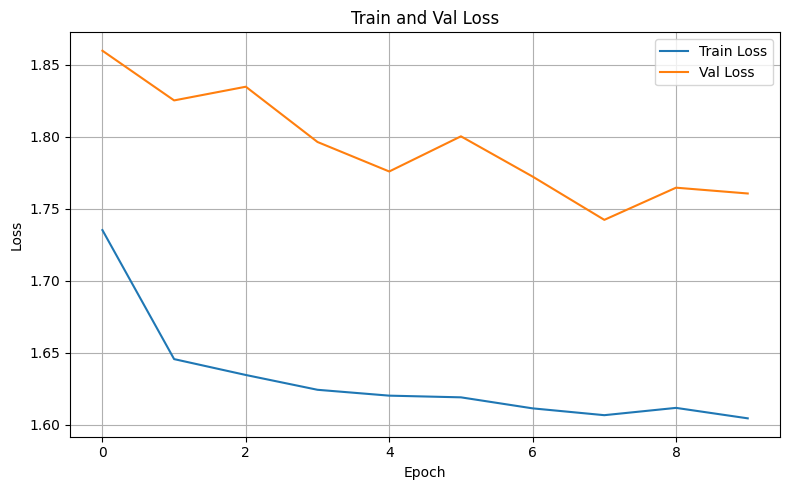

In [ ]:
plot_losses_(losses_train_contrastive, losses_val_contrastive)  # plot losses

# Query com modelo treinado com Contrastive Loss

Espera-se que as Cosine Similarities sejam mais próximas de zero para pares negativos!

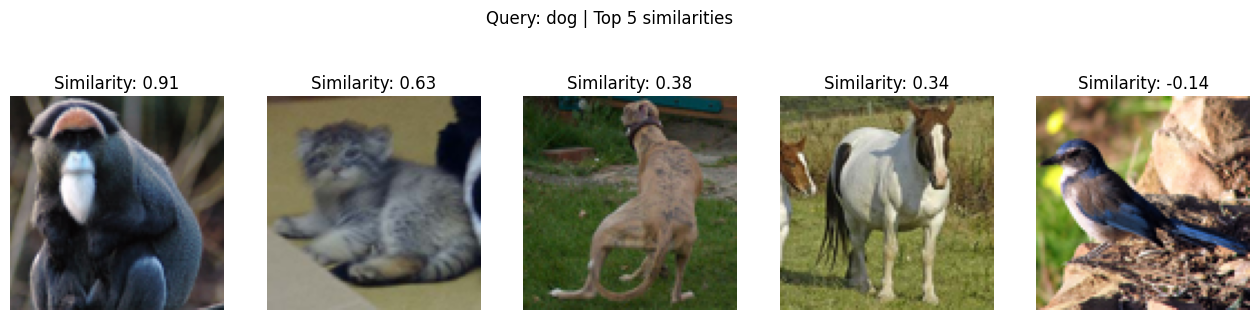

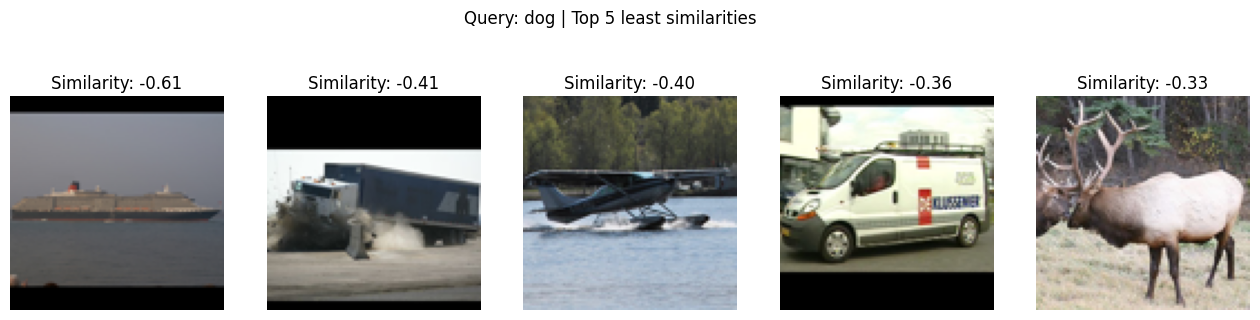

2

In [ ]:
query(model_contrastive, "dog", batch['image'], plot_image=False, plot_top_images=5)  # retorna o índice da imagem

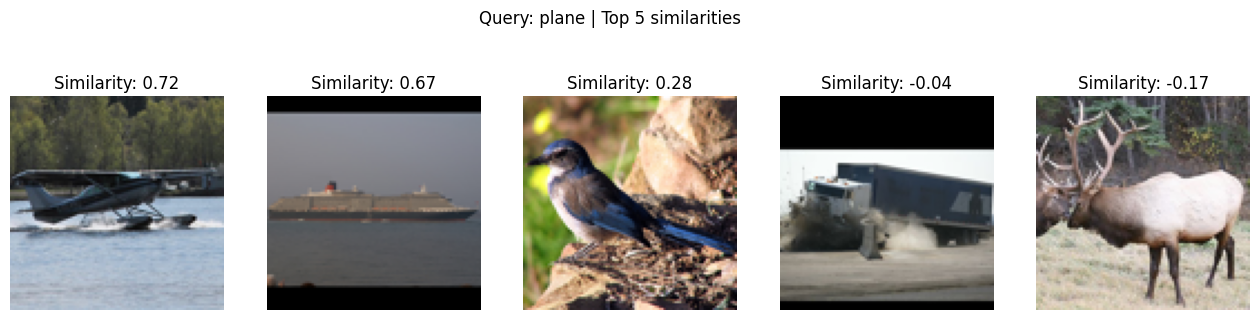

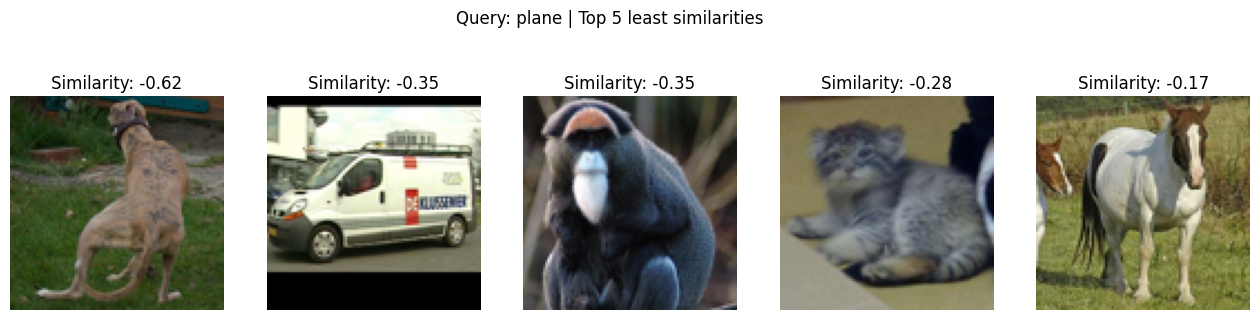

8

In [ ]:
query(model_contrastive, "plane", batch['image'], plot_image=False, plot_top_images=5)  # retorna o índice da imagem

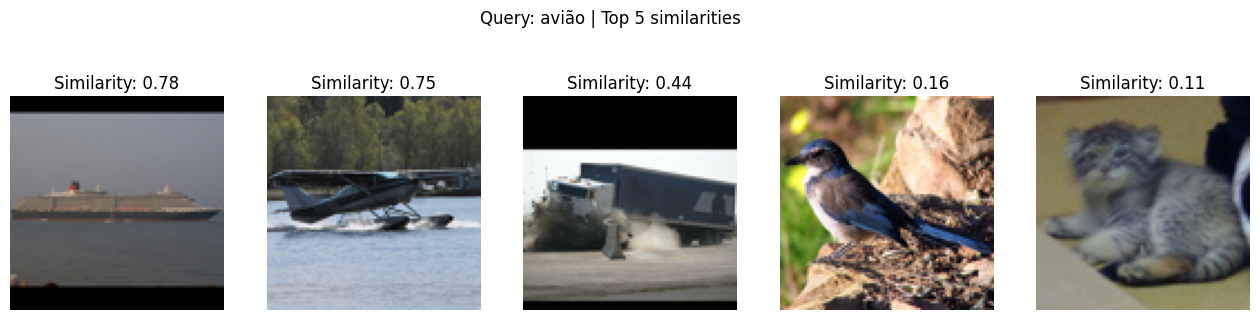

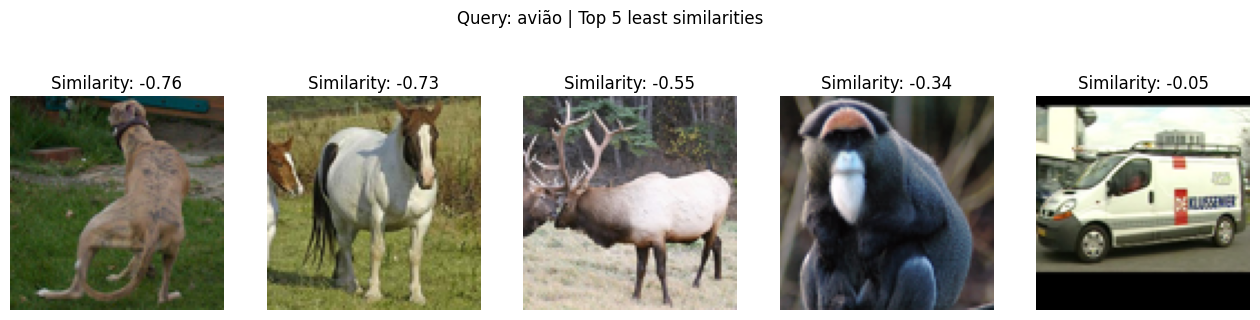

0

In [ ]:
query(model_contrastive, "avião", batch['image'], plot_image=False, plot_top_images=5)  # retorna o índice da imagem

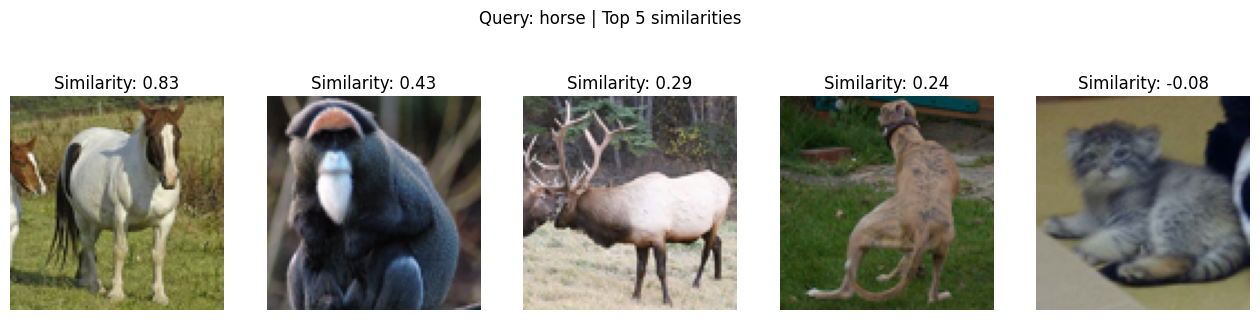

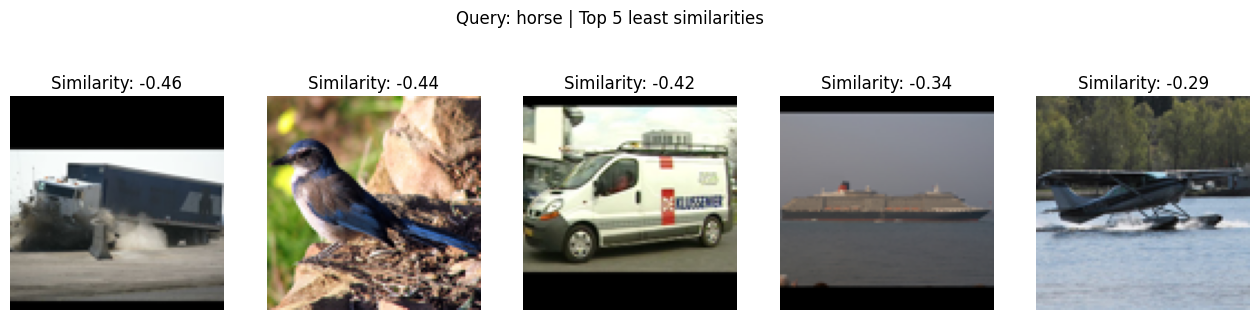

6

In [ ]:
query(model_contrastive, "horse", batch['image'], plot_image=False, plot_top_images=5)